# Unrolling neural network training

In [8]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)

import warnings
warnings.filterwarnings("ignore")


## Toy case models and datasets

In [9]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to match model output shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape y_test to match model output shape

In [20]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

In [21]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}, Dtype: {param.dtype}")

Parameter name: 0.weight, Shape: torch.Size([30, 13]), Dtype: torch.float32
Parameter name: 0.bias, Shape: torch.Size([30]), Dtype: torch.float32
Parameter name: 2.weight, Shape: torch.Size([1, 30]), Dtype: torch.float32
Parameter name: 2.bias, Shape: torch.Size([1]), Dtype: torch.float32


### Simple training loop 

In [22]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 116.2047
Epoch [20/100], Loss: 40.2300
Epoch [30/100], Loss: 21.5361
Epoch [40/100], Loss: 16.2013
Epoch [50/100], Loss: 13.5249
Epoch [60/100], Loss: 11.8810
Epoch [70/100], Loss: 10.5504
Epoch [80/100], Loss: 9.7938
Epoch [90/100], Loss: 9.2201
Epoch [100/100], Loss: 8.6951
Test Loss: 11.3871


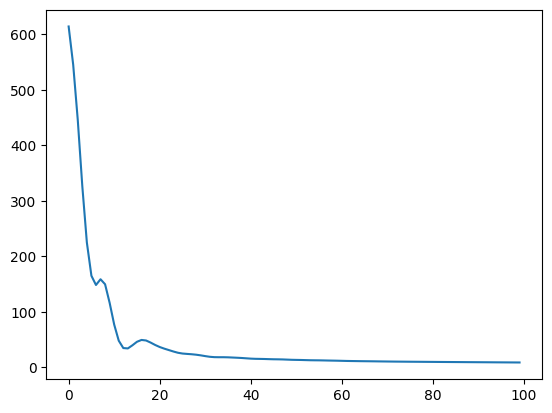

In [24]:
plt.plot(train_losses)

### SCA for training

Let's try to define a surrogate loss using a general purpose second order approximations and the gradient of the feedforward network. 